In [105]:
%reload_ext autoreload
%autoreload 2

In [106]:
from xai_cola import data_interface 
from xai_cola import ml_model_interface
from counterfactual_explainer import DiCE,DisCount
from xai_cola.cola_policy.matching import CounterfactualExactMatchingPolicy
from xai_cola.counterfactual_limited_actions import COLA

#### 0. Pick the data to be factual("Risk"=1)

In [107]:
from test_dataset.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
df = dataset.get_dataframe()
df.head(3)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,0
1,22,0,2,1,1,2,5951,48,5,1
2,49,1,1,1,1,0,2096,12,3,0


In [108]:
# pick 4 samples with Risk = 1
df_Risk_1 = df[df['Risk'] == 1]
df_Risk_1 = df_Risk_1.sample(6)

# drop the target column.
# Normally, the input data doesn't contain the target column
df_without_target = df_Risk_1.drop(columns=['Risk']).copy()
feature_names = df_without_target.columns
df_without_target.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
197,27,0,2,2,2,2,951,12,4
634,25,0,1,1,1,2,1355,24,1
454,31,1,2,1,1,1,4817,24,1
596,23,0,2,2,1,1,1442,24,1
15,32,0,1,1,2,1,1282,24,5


#### 1. Initialize data interface

In [109]:
data1 = data_interface.PandasData(df_without_target, target_name='Risk')

#### 2. Initialize model interface

In [110]:
import joblib
lgbmcClassifier = joblib.load('lgbm_GremanCredit.pkl')
print(f'----lgbm_GremanCredit.pkl model has been loaded----')

----lgbm_GremanCredit.pkl model has been loaded----


In [111]:
ml_model1 = ml_model_interface.Model(model=lgbmcClassifier, backend="sklearn")

#### 3.Choose the CounterfactualExplanation Algorithm

In [112]:
explainer = DiCE(ml_model=ml_model1)
explainer_discount = DisCount(ml_model=ml_model1)

In [113]:
factual, counterfactual = explainer.generate_counterfactuals(data=data1,
                                                             factual_class=1,
                                                             total_cfs=1,
                                                             features_to_keep=['Age','Sex'])

100%|██████████| 6/6 [00:00<00:00,  9.47it/s]


#### 4. Choose policy and make limitation

In [114]:
refiner = COLA(
            data=data1,
            ml_model=ml_model1,
            x_factual=factual,
            x_counterfactual=counterfactual,
            )
refiner.set_policy(
            matcher="ect",
            attributor="pshap",
            Avalues_method="max"
            )

You choose the Policy: pshap With Exact Matching, Avalues_method is max


In [115]:
""" Here! control the limited actions """
factual, ce, ace = refiner.get_refined_counterfactual(limited_actions=7)

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.02914475 0.69187346]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.28868069 0.02056964]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.02085537  0.65714961]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.53633698 0.10245351]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.74194351 0.        ]


#### 5.Highlight the generated counterfactuals

In [116]:
refine_factual, refine_ce, refine_ace = refiner.highlight_changes()

In [117]:
print("factual")
display(factual)
print("factaul -> corresponding counterfactual")
display(refine_ce)
print("factual -> action-limited counterfactual")
display(refine_ace)

factual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,0,2,2,2,2,951,12,4,1
1,25,0,1,1,1,2,1355,24,1,1
2,31,1,2,1,1,1,4817,24,1,1
3,23,0,2,2,1,1,1442,24,1,1
4,32,0,1,1,2,1,1282,24,5,1
5,53,0,3,1,0,0,7485,30,1,1


factaul -> corresponding counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,0,2,2,2,2,951 -> 3939,12,4,1 -> 0
1,25,0,1 -> 2,1,1,2,1355 -> 6180,24,1,1 -> 0
2,31,1,2,1,1,1,4817 -> 6489,24 -> 29,1,1 -> 0
3,23,0,2 -> 1,2,1,1,1442 -> 5934,24,1,1 -> 0
4,32,0,1,1,2,1,1282 -> 4851,24 -> 30,5,1 -> 0
5,53,0,3,1,0,0,7485 -> 2021,30,1 -> 2,1 -> 0


factual -> action-limited counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,0,2,2,2,2,951 -> 3939,12,4,1 -> 0
1,25,0,1,1,1,2,1355 -> 6180,24,1,1 -> 0
2,31,1,2,1,1,1,4817 -> 6489,24,1,1 -> 0
3,23,0,2,2,1,1,1442 -> 5934,24,1,1 -> 0
4,32,0,1,1,2,1,1282 -> 4851,24 -> 30,5,1 -> 0
5,53,0,3,1,0,0,7485 -> 2021,30,1,1 -> 0


changes from factual to counterfactual


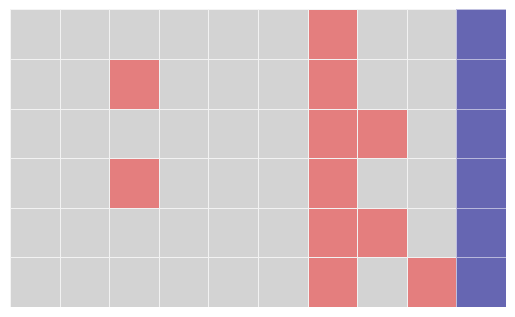

changes from factual to actionlimited_counterfactuals


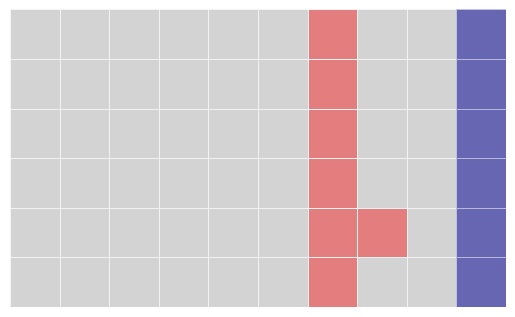

(None, None)

In [118]:
refiner.heatmap()